Note
- [Colab Only] Means the associated cell is required only if you are running the model on Google Colaboratory

## Mount Drive [Colab Only]
Mount the google drive to access the dataset stored on drive.

In [1]:
%load_ext autoreload
%autoreload 2
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import zipfile
path = '/gdrive/Shared\ drives/CS230\ -\ Term\ Project/data/BraTS_2018/MICCAI_BraTS_2018_Data_Training/'
path_python = '/gdrive/Shared drives/CS230 - Term Project/data/BraTS_2018/MICCAI_BraTS_2018_Data_Training/'
%ls $path

HGG/  LGG/  survival_data.csv


## Extract the Dataset

In [3]:
# import zipfile  # For faster extraction
# dataset_path = "/gdrive/My Drive/MICCAI_BraTS_2018_Data_Training.zip"  # Replace with your dataset path
# zfile = zipfile.ZipFile(dataset_path)
# zfile.extractall()

## Get required packages
- **SimpleITK**: For loading the dataset
- **[model.py](https://github.com/IAmSuyogJadhav/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization/)**: The model from BRATS2018 winning paper

In [4]:
!pip install simpleitk
# !wget https://github.com/IAmSuyogJadhav/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization/raw/master/model.py
!cp '/gdrive/Shared drives/CS230 - Term Project/code/ae_model.py' .

     |████████████████████████████████| 44.9MB 98kB/s 


## Imports and helper functions

In [5]:
# !pip install keras

In [6]:
import SimpleITK as sitk  # For loading the dataset
import numpy as np  # For data manipulation
from ae_model import build_model  # For creating the model
import glob  # For populating the list of files
from scipy.ndimage import zoom  # For resizing
import re  # For parsing the filenames (to know their modality)
import os

from keras.callbacks import History 
history = History()

In [7]:
def read_img(img_path):
    """
    Reads a .nii.gz image and returns as a numpy array.
    """
    return sitk.GetArrayFromImage(sitk.ReadImage(img_path))

In [8]:
def resize(img, shape, mode='constant', orig_shape=(155, 240, 240), order=3):
    """
    Wrapper for scipy.ndimage.zoom suited for MRI images.
    """
    assert len(shape) == 3, "Can not have more than 3 dimensions"
    factors = (
        shape[0]/orig_shape[0],
        shape[1]/orig_shape[1], 
        shape[2]/orig_shape[2]
    )

    # Resize to the given shape
    return zoom(img, factors, mode=mode, order=order)


def preprocess(img, out_shape=None):
    """
    Preprocess the image.
    Just an example, you can add more preprocessing steps if you wish to.
    """
    if out_shape is not None:
        img = resize(img, out_shape, mode='constant')
    
    # Normalize the image
    mean = img.mean()
    std = img.std()
    return (img - mean) / std


def preprocess_label(img, out_shape=None, mode='nearest'):
    """
    Separates out the 3 labels from the segmentation provided, namely:
    GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2))
    and the necrotic and non-enhancing tumor core (NCR/NET — label 1)
    """
    ncr = img == 1  # Necrotic and Non-Enhancing Tumor (NCR/NET)
    ed = img == 2  # Peritumoral Edema (ED)
    et = img == 4  # GD-enhancing Tumor (ET)
    print(ncr)
    
    if out_shape is not None:
        ncr = resize(ncr, out_shape, mode=mode)
        ed = resize(ed, out_shape, mode=mode)
        et = resize(et, out_shape, mode=mode)

    return np.array([ncr, ed, et], dtype=np.uint8)

def unprocess_label(img, out_shape=None, mode='nearest'):
    """
    Recombines the 3 labels to the segmentation format from brats.
    """
    ncr = img[0]
    ed = img[1]
    et = img[2]
    # ncr = img[0,:,:,:] # Necrotic and Non-Enhancing Tumor (NCR/NET)
    # ed = img[1,:,:,:]  # Peritumoral Edema (ED)
    # et = img[2,:,:,:]  # GD-enhancing Tumor (ET)
    print(np.unique(ncr))
    print(np.unique(ed))
    print(np.unique(et))
    
    if out_shape is not None:
        ncr = resize(ncr, out_shape, mode=mode, orig_shape=(80, 96, 64), order=0)
        ed = resize(ed, out_shape, mode=mode, orig_shape=(80, 96, 64), order=0)
        et = resize(et, out_shape, mode=mode, orig_shape=(80, 96, 64), order=0)

    # update label values
    # no update needed for ncr
    ed = np.where(ed == 1,2,0)
    et = np.where(et == 1,4,0)

    out = ncr + ed + et

    print(np.unique(ncr))
    print(np.unique(ed))
    print(np.unique(et))
    
    print('out')
    print(out.shape)
    print(np.unique(out))
    # return np.array([ncr, ed, et], dtype=np.uint8)
    return out
    

In [9]:
b = np.zeros((3,3))
b[1,0:-1] =1
np.where(b == 1,2,0)

array([[0, 0, 0],
       [2, 2, 0],
       [0, 0, 0]])

In [10]:
# out = unprocess_label(a, out_shape=(155, 240, 240))
# np.unique(a[2])

In [12]:
# c = read_img(imgs['seg'])

In [13]:
# np.array_equal(out,c)

## Loading Data


In [14]:
# Get a list of files for all modalities individually
t1 = glob.glob(os.path.join(path_python,'*GG/*/*t1.nii.gz'))
t2 = glob.glob(os.path.join(path_python,'*GG/*/*t2.nii.gz'))
flair = glob.glob(os.path.join(path_python,'*GG/*/*flair.nii.gz'))
t1ce = glob.glob(os.path.join(path_python,'*GG/*/*t1ce.nii.gz'))
seg = glob.glob(os.path.join(path_python,'*GG/*/*seg.nii.gz'))  # Ground Truth

In [ ]:
# seg

Parse all the filenames and create a dictionary for each patient with structure:

{<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'t1': _<path to t1 MRI file&gt;_,<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'t2': _<path to t2 MRI&gt;_,<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'flair': _<path to FLAIR MRI file&gt;_,<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'t1ce': _<path to t1ce MRI file&gt;_,<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'seg': _<path to Ground Truth file&gt;_,<br />
}<br />

In [15]:
pat = re.compile('.*_(\w*)\.nii\.gz')

data_paths = [{
    pat.findall(item)[0]:item
    for item in items
}
for items in list(zip(t1, t2, t1ce, flair, seg))]


# data_paths = {
#     't1': t1,
#     't2': t2,
#     'flair': flair,
#     't1ce': t1ce,
#     'seg': seg
# }

In [22]:
import random
a = list(range(10))
random.shuffle(a)
print(a)

a = list(range(10))
random.shuffle(a)
print(a)

a = list(range(10))
random.Random(1).shuffle(a)
print(a)

a = list(range(10))
random.Random(1).shuffle(a)
print(a)

[7, 9, 5, 6, 1, 2, 4, 3, 0, 8]
[6, 1, 5, 3, 9, 2, 4, 0, 8, 7]
[6, 8, 9, 7, 5, 3, 0, 4, 1, 2]
[6, 8, 9, 7, 5, 3, 0, 4, 1, 2]


## Load the data in a Numpy array
Creating an empty Numpy array beforehand and then filling up the data helps you gauge beforehand if the data fits in your memory.



_Loading only the first 4 images here, to save time._

In [ ]:
input_shape = (4, 80, 96, 64)
output_channels = 3
data = np.empty((len(data_paths[:4]),) + input_shape, dtype=np.float32)
labels = np.empty((len(data_paths[:4]), output_channels) + input_shape[1:], dtype=np.uint8)

In [ ]:
import math

# Parameters for the progress bar
total = len(data_paths[:4])
step = 25 / total

for i, imgs in enumerate(data_paths[:4]):
    try:
        data[i] = np.array([preprocess(read_img(imgs[m]), input_shape[1:]) for m in ['t1', 't2', 't1ce', 'flair']], dtype=np.float32)
        labels[i] = preprocess_label(read_img(imgs['seg']), input_shape[1:])[None, ...]
        
        # Print the progress bar
        print('\r' + f'Progress: '
            f"[{'=' * int((i+1) * step) + ' ' * (24 - int((i+1) * step))}]"
            f"({math.ceil((i+1) * 100 / (total))} %)",
            end='')
    except Exception as e:
        print(f'Something went wrong with {imgs["t1"]}, skipping...\n Exception:\n{str(e)}')
        continue

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False Fal

In [ ]:
np.mean(data[0])
# data[1]
# data[0]

-1.2665987e-08

In [ ]:
a = preprocess_label(read_img(imgs['seg']),input_shape[1:])
a

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False Fal

array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        ...,

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
    

In [ ]:
read_img(imgs['seg']).shape

(155, 240, 240)

In [ ]:
a.shape

(3, 80, 96, 64)

## Model

build the model

Train the model

In [ ]:
model = build_model(input_shape=input_shape, output_channels=3)

In [ ]:
model.fit(data, [labels, data], batch_size=1, epochs=3, callbacks=[history])

Train on 4 samples
Epoch 1/3
4/4 [==============================] - 3s 727ms/sample - loss: 0.2952 - Dec_GT_Output_loss: -7.0373e-04 - Dec_VAE_Output_loss: 0.2959 - Dec_GT_Output_dice_coefficient: 7.0373e-04 - Dec_VAE_Output_dice_coefficient: 0.1176
Epoch 2/3
4/4 [==============================] - 3s 744ms/sample - loss: 0.1275 - Dec_GT_Output_loss: -0.0011 - Dec_VAE_Output_loss: 0.1286 - Dec_GT_Output_dice_coefficient: 0.0011 - Dec_VAE_Output_dice_coefficient: 0.1322
Epoch 3/3
4/4 [==============================] - 3s 742ms/sample - loss: 0.0770 - Dec_GT_Output_loss: -0.0011 - Dec_VAE_Output_loss: 0.0781 - Dec_GT_Output_dice_coefficient: 0.0011 - Dec_VAE_Output_dice_coefficient: 0.1171


In [ ]:
print(history.history)

{'loss': [0.29521334916353226, 0.1274555418640375, 0.07699200324714184], 'Dec_GT_Output_loss': [-0.0007037346, -0.0011463077, -0.0011440045], 'Dec_VAE_Output_loss': [0.2959171, 0.12860185, 0.078136005], 'Dec_GT_Output_dice_coefficient': [0.0007037346, 0.0011463077, 0.0011440045], 'Dec_VAE_Output_dice_coefficient': [0.11764589, 0.13218403, 0.1171082]}


In [ ]:
predictions = model.predict(data)
data[1].shape

(4, 80, 96, 64)

# **Evaluations + Loss Metrics**

In [ ]:
import tensorflow as tf
import keras.backend as K
from sklearn.utils.extmath import cartesian

Dice Score

In [ ]:
def dice_coef(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

Hausdorff Loss

In [ ]:
# taken from https://jeune-research.tistory.com/entry/Loss-Functions-for-Image-Segmentation-Distance-Based-Losses

class HausdorffLoss:
    def __init__(self, W, H, alpha = 2):
        self.W = W
        self.H = H
        self.alpha = alpha
        self.all_img_locations = tf.convert_to_tensor(cartesian([np.arange(W), np.arange(H)]), dtype=tf.float32)
        self.max_dist = math.sqrt(W**2 + H**2)

    def cdist (self,A, B):  
        na = tf.reduce_sum(tf.square(A), 1)
        nb = tf.reduce_sum(tf.square(B), 1)
        na = tf.reshape(na, [-1, 1])
        nb = tf.reshape(nb, [1, -1])
        D = tf.sqrt(tf.maximum(na - 2*tf.matmul(A, B, False, True) + nb, 0.0))
        return D
   
    def weighted_hausdorff_distance(self,y_true, y_pred):
            all_img_locations = self.all_img_locations
            W = self.W
            H = self.H
            alpha = self.alpha
            max_dist = self.max_dist
            eps = 1e-6
    
            y_true = K.reshape(y_true, [W,H])
            gt_points = K.cast(tf.where(y_true > 0.5), dtype = tf.float32)
            num_gt_points = tf.shape(gt_points)[0]
        
            y_pred = K.flatten(y_pred)
            p = y_pred
            p_replicated = tf.squeeze(K.repeat(tf.expand_dims(p,axis=-1), num_gt_points))
        
            d_matrix = self.cdist(all_img_locations, gt_points)
            num_est_pts = tf.reduce_sum(p)
            term_1 = (1 / (num_est_pts + eps)) * K.sum(p * K.min(d_matrix, 1))
        
        
            d_div_p = K.min((d_matrix + eps) / (p_replicated**alpha + (eps / max_dist)), 0)
            d_div_p = K.clip(d_div_p, 0, max_dist)
            term_2 = K.mean(d_div_p, axis=0) 
        
            return term_1 + term_2
            
        
    def hausdorff_loss(self,y_true, y_pred):
        batched_losses = tf.map_fn(lambda x: 
                self.weighted_hausdorff_distance(x[0], x[1]), 
                (y_true, y_pred), 
                dtype=tf.float32)
        return K.mean(tf.stack(batched_losses))

In [ ]:
print("Evaluate on test data:")
results = model.evaluate(data, [labels, data], batch_size=1)
print("     test loss, test acc:", results)
print("Dice coefficient: " + str(dice_coef(data_paths[4], predictions))) # data_paths[4] is wrong; I need to find the right way to get the ground truth images
print("Dice loss: " + str(dice_coef_loss(data_paths[4], predictions))) # same as above
print ("Hausdorff Loss: " + str(HausdorffLoss.weighted_hausdorff_distance(data_paths[4], predictions))) # same as above

Evaluate on test data:
     test loss, test acc: [0.0573259461671114, -0.0066739894, 0.063999936, 0.0066739894, 0.1291602]


That's it!

## Closing Regards

If you are resizing the segmentation mask, the resized segmentation mask retains the overall shape, but loses a lot of pixels and becomes somewhat 'grainy'. See the illustration below.

1. Original segmentation mask:

(240, 240)
[0 1]
2111


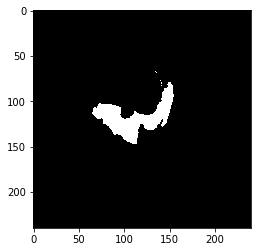

In [ ]:
import matplotlib.pyplot as plt
img = (read_img(seg[0])[100] == 2).astype(np.uint8)
print(img.shape)
print(np.unique(img))
print(img.sum())
plt.imshow(img, cmap='Greys_r')

After resizing to (80, 96, 64)

(96, 64)
[0 1]
116


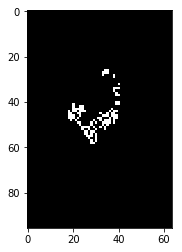

In [ ]:
img = preprocess_label(read_img(seg[0]), out_shape=(80, 96, 64), mode='nearest')[1][50]
print(img.shape)
print(np.unique(img))
print(img.sum())
plt.imshow(img, cmap='Greys_r')

One can clearly notice that there are now a lot of black pixels in the region where there should have been only white pixels. This can potentially hurt our model. So, it is best to not resize the image too much. But, due to computational constraints and the model requirements, it is unavoidable. 

However, given below are a few things one could try to reduce the downsampling noise as much as possible.

In [ ]:
import cv2

- Original Image > preprocess_label > Morphological Closing

[0 1]
491


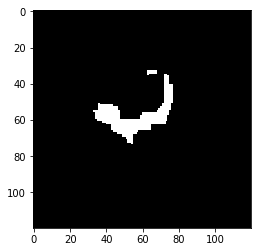

In [ ]:
kernel = np.ones((3, 3))
img_closed = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)
print(np.unique(img_closed))
print(img_closed.sum())
plt.imshow(img_closed, cmap='Greys_r')

- Original Image > preprocess_label > Morphological Dilation

[0 1]
660


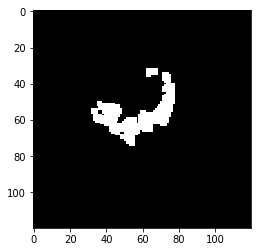

In [ ]:
kernel = np.ones((3, 3))
img_dilated = cv2.dilate(img, kernel, iterations=1)
print(np.unique(img_dilated))
print(img_dilated.sum())
plt.imshow(img_dilated, cmap='Greys_r')

You could try these things to get even better results.

## Feedback

If you have any feedback, queries, bug reports to send, please feel free to [raise an issue](https://github.com/IAmSuyogJadhav/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization/issues/new) on github. It would be really helpful!